In [49]:
import numpy as np
import matplotlib.pyplot as plt
from models import NN, train_NN
import torch
from tqdm import tqdm_notebook as tqdm
import math

In [96]:
# LF evaluation function
def x_L(xi):
    return xi

# gradient of x_L
def grad_x_L(xi):
    return 1.0

# sampling xi by p(xi)
def sample_xi_p(N):
    return torch.rand(N, 1)

ExL   = x_L(sample_xi_p(int(1e6))).mean()
bound = torch.tensor([0,1])

def score(xi, l): #score function, return grad q(xi)
    grad_xL = grad_x_L(xi)
    return (ExL - x_L(xi))/(l**2) * grad_xL

def sample_xi_q(l=0.1, 
                iter_num=int(1e5),
                eta=1e-3): # sample xi by q(x)
    burn_in = int(1e6)
    xi_init = torch.randn(1)
    smps = []
    for s in tqdm(range(iter_num+burn_in)):
        xi_new  = xi_init + eta * score(xi_init, l) + np.sqrt(2*eta)*torch.randn_like(xi_init)
        smps.append(xi_new)
    return torch.cat(smps,0)[burn_in:]

## Langevin Algorithm
Langevin algorithm is the discretization of the following SDE
$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t,$$
where the SDE has solution $p(x) = \exp(-U(x))$. 
Function $U(x)$ is called potential. 

In a 2D case, if we let potential function 
$$U(\mathbf{x}) = \lVert \mathbf{x} - \mathbf{0.5}\rVert^2/2\ell^2,$$
then the solution is a multivariate Gaussian with covariance matrix $\ell^2\mathbf{I}$. 
It also corresponds to the case that LF function is identity. 

In [158]:
def potential(z,l):
    return torch.norm(z - 0.5)**2/(2.0*l**2)

def unadjusted_langevin_algorithm(potential, iter_num=100000, step=1e-2, l=1.0, burn_in=int(1e4)):
    Z0 = torch.rand(1, 2)
    Zi = Z0
    samples = []
    for i in tqdm(range(iter_num + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi,l).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        Zi = Zi.detach() - step * l**2 * grad + np.sqrt(2 * step * l**2) * torch.randn(1, 2)
        samples.append(Zi.detach().numpy())
    return np.concatenate(samples, 0)[burn_in:]

<ipython-input-158-57a81db33c52>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iter_num + burn_in)):


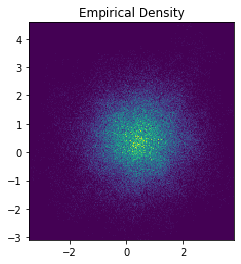

In [159]:
samples1 = unadjusted_langevin_algorithm(potential)
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Empirical Density')
plt.show()

<ipython-input-158-57a81db33c52>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iter_num + burn_in)):


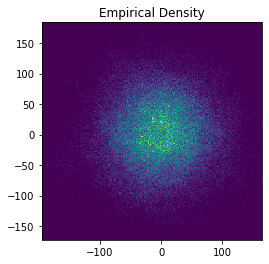

In [162]:
samples2 = unadjusted_langevin_algorithm(potential,l=50.0)
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Empirical Density')
plt.show()

<ipython-input-158-57a81db33c52>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(iter_num + burn_in)):


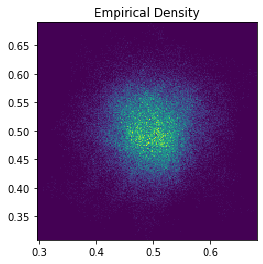

In [161]:
samples4 = unadjusted_langevin_algorithm(potential,l=0.05)
plt.hist2d(samples4[:,0], samples4[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Empirical Density')
plt.show()

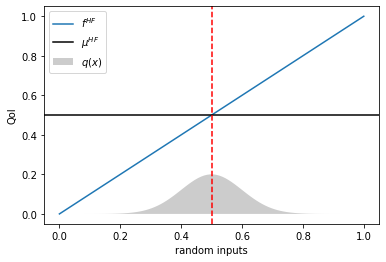

In [177]:
from scipy.stats import norm
x = np.linspace(0,1,100)
y = norm.pdf(x,0.5,0.1)
plt.plot(x,x,label='$f^{HF}$')
plt.axhline(0.5,color='k',label=r'$\mu^{HF}$')
plt.axvline(0.5,color='r',ls='--')
plt.fill(x,(y-y[0])/(5*y[50]), fc="black", alpha=0.2, label=r"$q(x)$")
plt.xlabel('random inputs')
plt.ylabel('QoI')
plt.legend()
plt.savefig('q.png',dpi=300)